In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch 
from torch.autograd import Variable
import torch.nn as nn
from torch.nn import Conv2d, InstanceNorm2d, ConvTranspose2d
from torch import optim 
import torch.nn.functional as F 
import torchvision

from torchvision.utils import save_image, make_grid

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# this won't work if the drive is shared with you
# solution: right click on the shared ML project folder and select 'add shortcut to my drive'
%cd gdrive/My\ Drive/ML_Project

/content/gdrive/.shortcut-targets-by-id/1za0atAODg4mE1kjNKlsja9o9kiFmFfUY/ML_Project


In [ ]:
class bVAE(nn.Module):
  def __init__(self, latent_dim):
    super(bVAE, self).__init__()
    self.latent_dim = latent_dim
    self.hwdim=6
    # Encoder
    self.c1 = nn.Conv2d(1, 32, kernel_size = 4, stride = 2, padding = 1)
    self.b1 = nn.BatchNorm2d(32)
    self.c2 = nn.Conv2d(32, 64, kernel_size = 4, stride = 2, padding = 1)
    self.b2 = nn.BatchNorm2d(64)
    self.c3 = nn.Conv2d(64, 64, kernel_size = 4, stride = 1, padding = 1)
    self.b3 = nn.BatchNorm2d(64)

    self.fc1 = nn.Linear(64 * self.hwdim * self.hwdim, latent_dim)
    self.fc2 = nn.Linear(64 * self.hwdim * self.hwdim, latent_dim)

    # Decoder
    self.fc3 = nn.Linear(latent_dim, 64 * self.hwdim * self.hwdim)
    self.d1 = nn.ConvTranspose2d(64, 64, kernel_size = 4, stride = 1, padding = 1)
    self.db1 = nn.BatchNorm2d(64)
    self.d2 = nn.ConvTranspose2d(64, 32, kernel_size = 4, stride = 2, padding = 1)
    self.db2 = nn.BatchNorm2d(32)
    self.d3 = nn.ConvTranspose2d(32, 1, kernel_size = 4, stride = 2, padding = 1)
    self.db3 = nn.BatchNorm2d(1)
    self.sigmoid = nn.Sigmoid()
  
  def encode(self, x):
    out = F.relu(self.b1(self.c1(x)))
    out = F.relu(self.b2(self.c2(out)))
    out = F.relu(self.b3(self.c3(out)))
    # Resize from (batch_size, num_classes, w, h) to (batch_size,num_classes*w*h)
    # print(out.shape)
    out = out.view(out.shape[0], -1)
    mu, logvar = F.relu(self.fc1(out)), F.relu(self.fc2(out))
    return mu, logvar
  
  def decode(self, z):
    out = F.relu(self.fc3(z))
    out = out.view(-1, 64, self.hwdim, self.hwdim)
    out = F.relu(self.db1(self.d1(out)))
    out = F.relu(self.db2(self.d2(out)))
    return self.sigmoid(self.db3(self.d3(out)))
  
  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    return mu + eps*std

  def forward(self, x):
    mu, logvar = self.encode(x)
    z = self.reparameterize(mu, logvar)
    return self.decode(z), mu, logvar

In [ ]:
class VAE_Loss(nn.Module):
  def __init__(self):
    super(VAE_Loss, self).__init__()
    self.beta = 3
  
  def forward(self, z_img, img, mu, logvar):
    BCE = torch.mean(F.binary_cross_entropy(z_img, img, reduction='sum'), dim = 0)
    KLD = torch.mean(-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim = 1), dim = 0)
    return BCE + self.beta * KLD

In [ ]:
batch_size = 128

In [ ]:
train_data_loader = torch.utils.data.DataLoader(
  torchvision.datasets.FashionMNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.Grayscale(num_output_channels=1),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size, shuffle=True)

test_data_loader = torch.utils.data.DataLoader(
  torchvision.datasets.FashionMNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.Grayscale(num_output_channels=1),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=32, shuffle=True)

Extracting /files/FashionMNIST/raw/train-images-idx3-ubyte.gz to /files/FashionMNIST/raw


Extracting /files/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /files/FashionMNIST/raw


Extracting /files/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /files/FashionMNIST/raw


Extracting /files/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /files/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
model = bVAE(20).to(device)
optimizer = optim.Adam(params = model.parameters(), lr=5e-3)
criterion = VAE_Loss()

In [ ]:
fixed_images, _ = next(iter(test_data_loader))

In [ ]:
def generate_samples(images, model):
  with torch.no_grad():
    out, _, _ = model(images)
  return out

In [ ]:
def evaluate_model(model, dataloader):
    """
    Calculates the average loss and accuracy of the model on a dataset
    """
    model.eval() # Notify all layers we're in eval mode instead of training mode
    loss = 0
    n = 0
    with torch.no_grad():
      for xs, _ in dataloader:
        xs = xs.to(device)
        out, mu, logvar = model(xs)
        loss += criterion(out, xs, mu, logvar).item()
        n += 1
    
    print(f'\nTest loss: {loss / n: .2f}')
    return loss / n

In [ ]:
epochs = 80
losses = []
best_loss = float('inf')

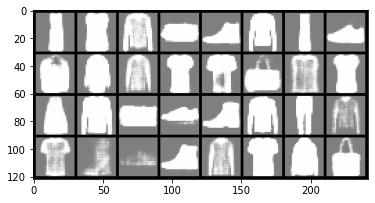

Epoch: 1, Avg Loss: -137241.1850


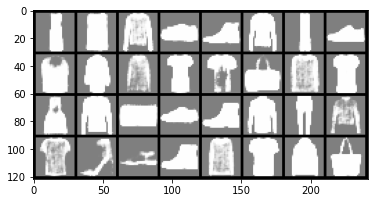

Epoch: 2, Avg Loss: -537012.2494
Epoch: 3, Avg Loss: -748502.5098


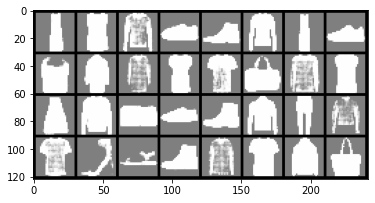

Epoch: 4, Avg Loss: -864480.8797
Epoch: 5, Avg Loss: -898404.7043


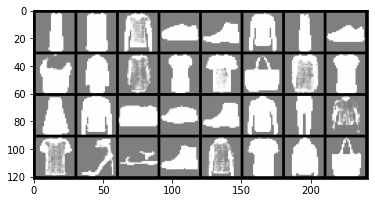

Epoch: 6, Avg Loss: -917106.8113
Epoch: 7, Avg Loss: -931834.1950


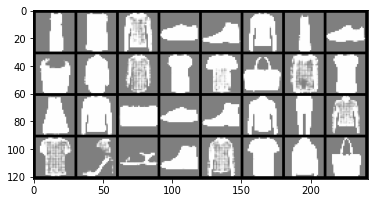

Epoch: 8, Avg Loss: -944980.9303
Epoch: 9, Avg Loss: -956951.9307


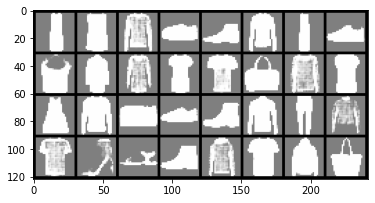

Epoch: 10, Avg Loss: -967043.8926
Epoch: 11, Avg Loss: -975537.4255


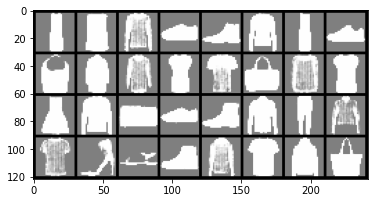

Epoch: 12, Avg Loss: -983209.9533
Epoch: 13, Avg Loss: -990127.8000


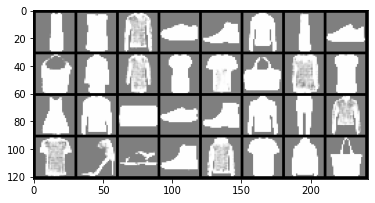

Epoch: 14, Avg Loss: -996315.2655
Epoch: 15, Avg Loss: -1002234.4758


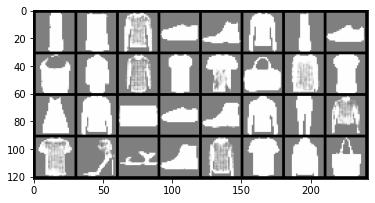

Epoch: 16, Avg Loss: -1007458.8370
Epoch: 17, Avg Loss: -1013104.9550


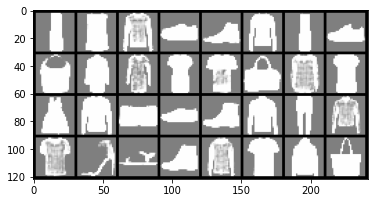

Epoch: 18, Avg Loss: -1017866.2003
Epoch: 19, Avg Loss: -1022352.7781


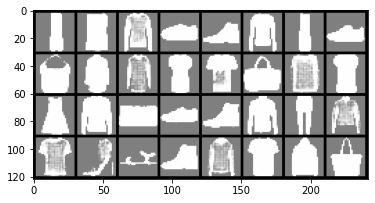

Epoch: 20, Avg Loss: -1026764.4300
Epoch: 21, Avg Loss: -1030916.4119


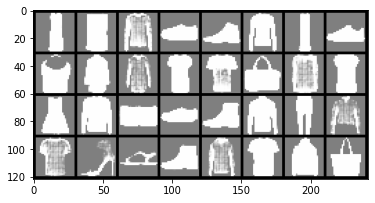

Epoch: 22, Avg Loss: -1034974.3496
Epoch: 23, Avg Loss: -1038295.1228


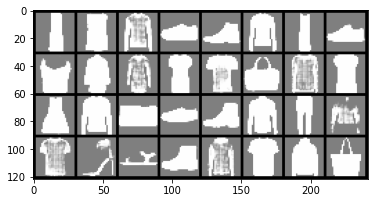

Epoch: 24, Avg Loss: -1041833.4901
Epoch: 25, Avg Loss: -1045458.7505


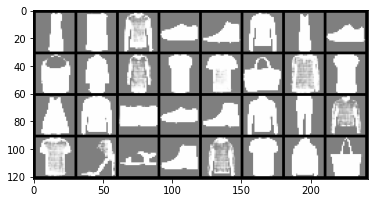

Epoch: 26, Avg Loss: -1048910.0201
Epoch: 27, Avg Loss: -1051629.5143


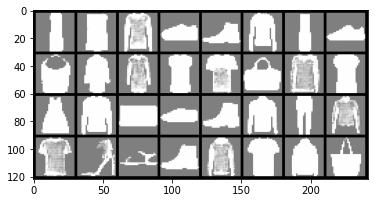

Epoch: 28, Avg Loss: -1054911.7976
Epoch: 29, Avg Loss: -1057794.8353


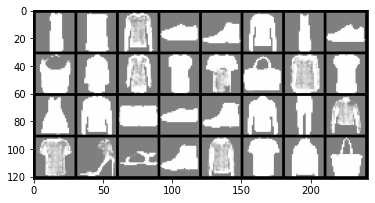

Epoch: 30, Avg Loss: -1060341.1282
Epoch: 31, Avg Loss: -1063088.0611


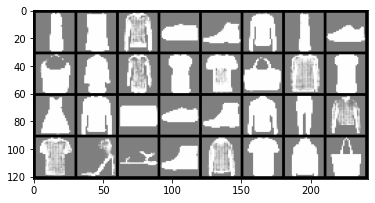

Epoch: 32, Avg Loss: -1065940.5734
Epoch: 33, Avg Loss: -1068470.7354


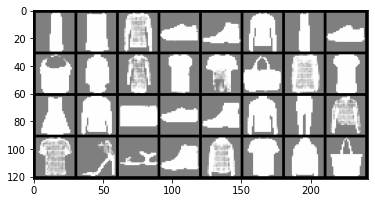

Epoch: 34, Avg Loss: -1071063.1604
Epoch: 35, Avg Loss: -1073423.6248


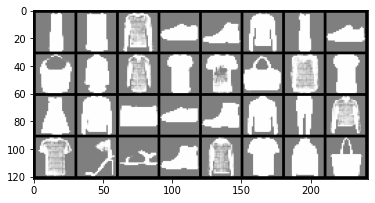

Epoch: 36, Avg Loss: -1075836.3822
Epoch: 37, Avg Loss: -1077902.6269


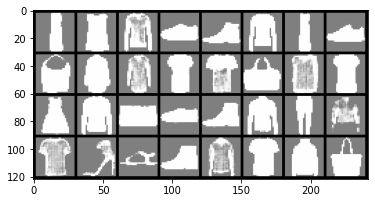

Epoch: 38, Avg Loss: -1080201.2195
Epoch: 39, Avg Loss: -1082514.7271


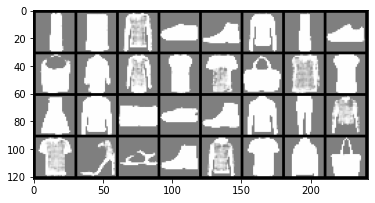

Epoch: 40, Avg Loss: -1084649.6381
Epoch: 41, Avg Loss: -1086709.1705


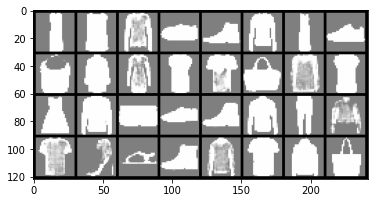

Epoch: 42, Avg Loss: -1088576.9644
Epoch: 43, Avg Loss: -1090323.5927


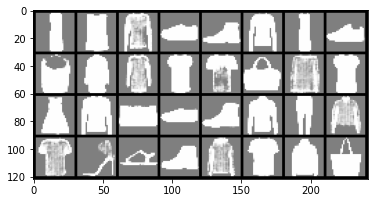

Epoch: 44, Avg Loss: -1092272.8719
Epoch: 45, Avg Loss: -1094639.3805


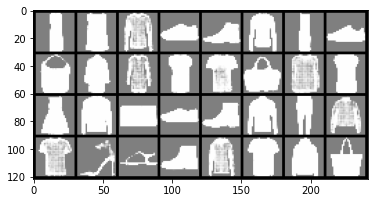

Epoch: 46, Avg Loss: -1096412.7630
Epoch: 47, Avg Loss: -1097940.2874


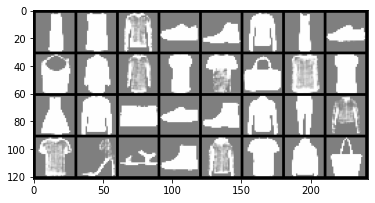

Epoch: 48, Avg Loss: -1099392.8778
Epoch: 49, Avg Loss: -1101420.5841


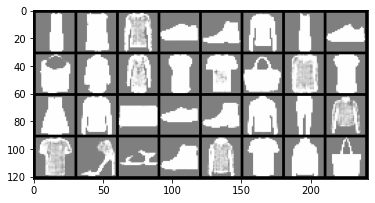

Epoch: 50, Avg Loss: -1102975.0137
Epoch: 51, Avg Loss: -1104263.6540


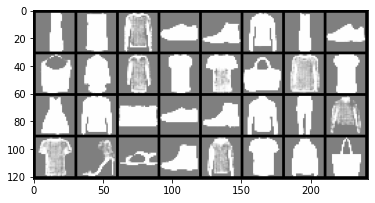

Epoch: 52, Avg Loss: -1106094.3489
Epoch: 53, Avg Loss: -1107647.8600


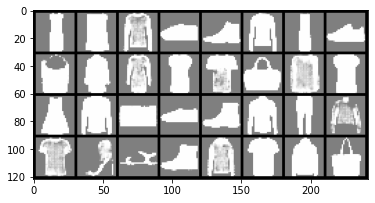

Epoch: 54, Avg Loss: -1109116.4728
Epoch: 55, Avg Loss: -1110665.9598


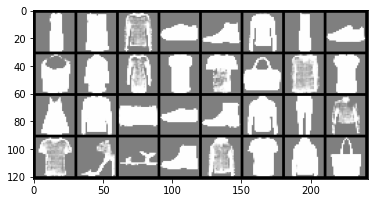

Epoch: 56, Avg Loss: -1112307.2903
Epoch: 57, Avg Loss: -1113707.3271


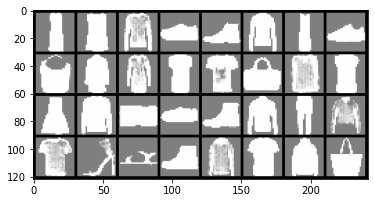

Epoch: 58, Avg Loss: -1115217.8872
Epoch: 59, Avg Loss: -1116547.1539


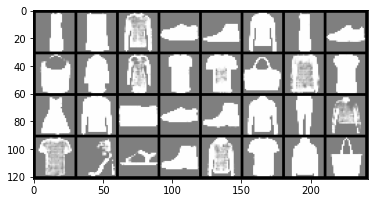

Epoch: 60, Avg Loss: -1117883.9092
Epoch: 61, Avg Loss: -1119150.8622


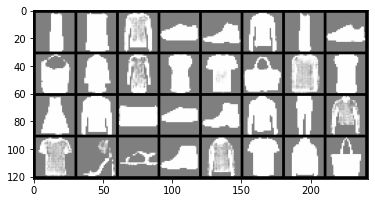

Epoch: 62, Avg Loss: -1120262.1975
Epoch: 63, Avg Loss: -1121610.7655


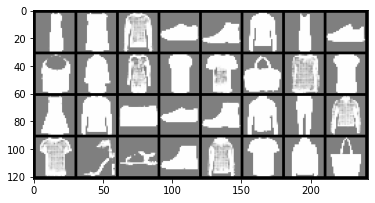

Epoch: 64, Avg Loss: -1122540.1276
Epoch: 65, Avg Loss: -1123569.8295


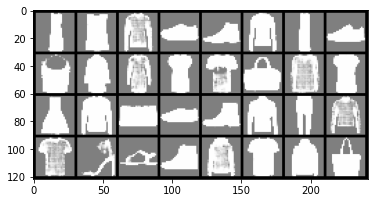

Epoch: 66, Avg Loss: -1125304.4027
Epoch: 67, Avg Loss: -1126075.0836


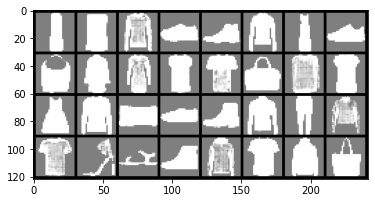

Epoch: 68, Avg Loss: -1127136.7183
Epoch: 69, Avg Loss: -1128351.0783


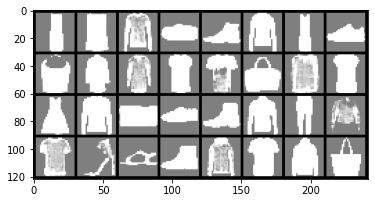

Epoch: 70, Avg Loss: -1129254.3740
Epoch: 71, Avg Loss: -1130506.7443


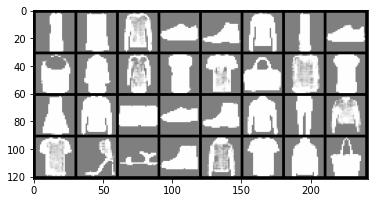

Epoch: 72, Avg Loss: -1131744.3032
Epoch: 73, Avg Loss: -1132445.4252


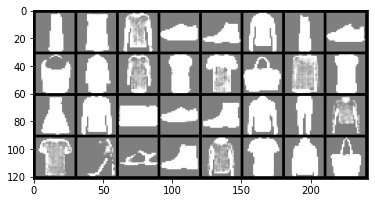

Epoch: 74, Avg Loss: -1133564.8460
Epoch: 75, Avg Loss: -1134469.7278


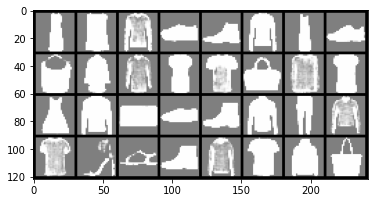

Epoch: 76, Avg Loss: -1135352.4186
Epoch: 77, Avg Loss: -1136568.5324


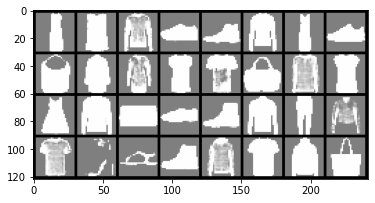

Epoch: 78, Avg Loss: -1137330.3643
Epoch: 79, Avg Loss: -1138784.1557


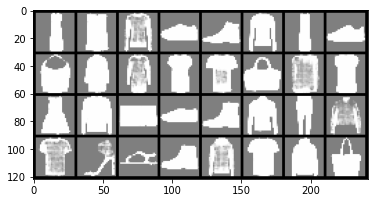

Epoch: 80, Avg Loss: -1139436.0553


In [ ]:
for epoch in range(1, epochs + 1):
  total = 0
  n = 0
  for x, _ in train_data_loader:
    x = x.to(device)
    optimizer.zero_grad()
    out, mu, logvar = model(x)
    loss = criterion(out, x, mu, logvar)
    loss.backward()
    optimizer.step()

    total += loss.item()
    n += 1
  
  avg_loss = total / n
  losses.append(avg_loss)

  if avg_loss < best_loss:
    best_loss = avg_loss
    with open('bVAE_FashionMNIST.pt', 'wb') as f:
      torch.save(model.state_dict(), f)
  
  if epoch == 1 or epoch % 2 == 0:
    model.eval()
    outputs = generate_samples(fixed_images.to(device), model)
    grid = make_grid(outputs.cpu(), nrow=8, range=(-1, 1), normalize=True)
    plt.imshow(grid.detach().permute(1, 2, 0))
    plt.show()
    model.train()

  print('Epoch: {}, Avg Loss: {:.4f}'.format(epoch, avg_loss))
  epoch += 1

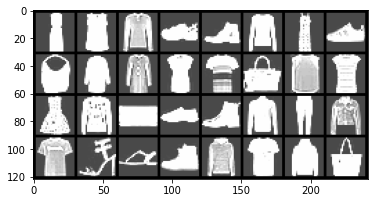

In [ ]:
# plot the actual test images
grid = make_grid(fixed_images, nrow=8, range=(-1, 1), normalize=True)
plt.imshow(grid.detach().permute(1, 2, 0))
plt.show()

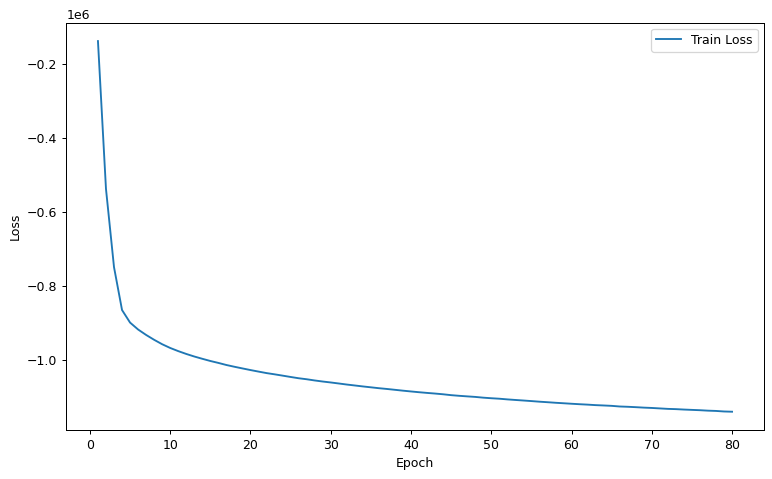

In [ ]:
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 90
plt.plot(list(range(1, epochs + 1)), losses)
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

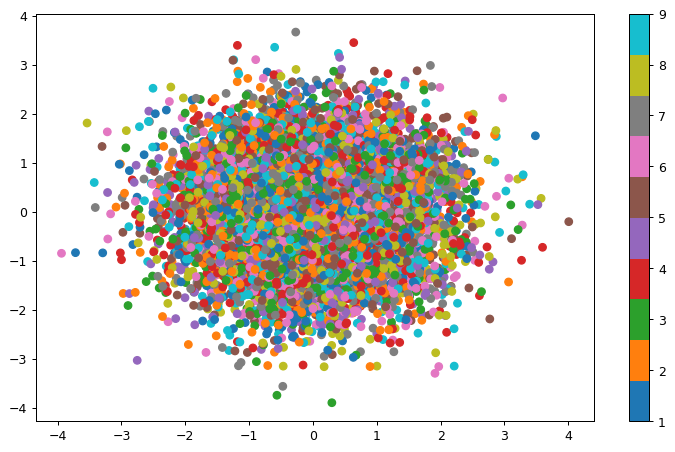

In [ ]:
# visualize latent space
for i, (x, y) in enumerate(test_data_loader):
  mu, logvar = model.encode(x.to(device))
  z = model.reparameterize(mu, logvar)
  z = z.to('cpu').detach().numpy()
  plt.scatter(z[:, 0], z[:, 1], c = y, cmap = 'tab10')
plt.colorbar()

In [ ]:
evaluate_model(model, test_data_loader)


Test loss: -1127794.10


-1127794.0986421725

In [ ]:
for x, _ in train_data_loader:
    x = x.to(device)
    print(type(x))
    print(x.shape)
    break

m_data_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size, shuffle=True)

for x, _ in m_data_loader:
    x = x.to(device)
    print(type(x))
    print(x.shape)
    break

<class 'torch.Tensor'>
torch.Size([32, 1, 28, 28])


Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw



Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw


Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw


Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw
Processing...
Done!
<class 'torch.Tensor'>
torch.Size([32, 1, 28, 28])
